# Main program

This code compares different payload alternatives to perform a planetary defense test as a part of an Asteroid Boulder-Capture Mission.

## Imports

In [1]:
import numpy as np
import pandas as pd

import expert_input
import alternative_physics
import new_fuzzy_weight_fucom_swara
import fuzzy_ranking
import sensitivity

## Input data processing

It generates a decision table for each expert and an aggregated one. The data of the tables is coming from computation or expert evaluation

In [2]:
def compute_cost(bus_new, instrument_complexity):
    return tuple(np.exp(1.52 * np.array(bus_new) + 0.467 * np.array(instrument_complexity)))

In [3]:
# Literature: https://www.sciencedirect.com/science/article/abs/pii/S0094576520304112 

# === Input processing mínimo (nuevo formato: cada experto es dict con 'data','criteria_order','chis') ===
experts = expert_input.experts

# alternativas detectadas (una sola vez)
alternatives_list = sorted({ d["alternative"] for e in experts for d in e["data"] })

# calcular test_time/test_mass una vez por alternativa
test_time_map = { alt: alternative_physics.test_time(alt) for alt in alternatives_list }
test_mass_map = { alt: alternative_physics.test_mass(alt) for alt in alternatives_list }

expert_decision_tables = []
expert_decision_matrices = []
expert_criteria_orders = []
expert_chis_list = []

for i, expert in enumerate(experts, start=1):
    data = expert["data"]

    # rellenar y calcular cost
    for row in data:
        alt = row["alternative"]
        row["test_time"] = test_time_map[alt]
        row["test_mass"] = test_mass_map[alt]

        b = row["bus_new"]
        ic = row["instrument_complexity"]
        row["cost"] = compute_cost(b, ic)   # aquí se inserta la columna 'cost'

    # forzar orden de columnas para que cost ocupe la posición que antes ocupaba 'maturity'
    cols_order = ["test_time", "test_mass", "tolerance", "interest", "cost", "risk"]
    df = pd.DataFrame(data).set_index("alternative")
    # si faltase alguna columna, la lista corta mantiene sólo las presentes
    df = df[[c for c in cols_order if c in df.columns]]

    matrix = [ tuple(df.loc[alt].tolist()) for alt in df.index ]

    expert_decision_tables.append(df)
    expert_decision_matrices.append(matrix)
    expert_criteria_orders.append(np.array(expert["criteria_order"]))
    expert_chis_list.append(expert["chis"])

    globals()[f"expert_decision_table_{i}"] = df
    globals()[f"expert_decision_matrix_TFN_{i}"] = matrix

    print(f"\nExpert_decision_table_{i} (id={expert.get('expert_id')})")
    print(df)

# Agregación (media componente-a-componente)
n_exp = len(expert_decision_tables)
alts = list(expert_decision_tables[0].index)
crits = list(expert_decision_tables[0].columns)

arr = np.zeros((n_exp, len(alts), len(crits), 3), dtype=float)

for e, df in enumerate(expert_decision_tables):
    for ai, alt in enumerate(alts):
        for cj, crit in enumerate(crits):
            l, m, u = df.at[alt, crit]
            arr[e, ai, cj, :] = (l, m, u)

mean = arr.mean(axis=0)   # shape (n_alt, n_crit, 3)

rows = []
for ai, alt in enumerate(alts):
    row = { crit: tuple(mean[ai, cj]) for cj, crit in enumerate(crits) }
    rows.append(row)
aggregated_decision_table = pd.DataFrame(rows, index=alts)
aggregated_decision_matrix_TFN = [ tuple(aggregated_decision_table.loc[alt, crits].tolist()) for alt in alts ]

print("\nDecision table aggregated")
print(aggregated_decision_table)



Expert_decision_table_1 (id=E1)
                                                     test_time  \
alternative                                                      
EGT          (24.77322196244031, 24.77322196244031, 24.7732...   
KI                                                (20, 20, 20)   
IBS          (5.24010144836404, 5.24010144836404, 5.2401014...   
LA           (2.4823346527815846, 2.4823346527815846, 2.482...   

                                                     test_mass  tolerance  \
alternative                                                                 
EGT          (32.87990418153415, 32.87990418153415, 32.8799...  (1, 3, 5)   
KI           (57.51940648325497, 57.51940648325497, 57.5194...  (5, 7, 9)   
IBS          (86.25528250795918, 86.25528250795918, 86.2552...  (3, 5, 7)   
LA           (215.61834062971508, 215.61834062971508, 215.6...  (1, 3, 5)   

              interest                                               cost  \
alternative                   

## Weight determination

It generates fuzzy weights based on Fuzzy-FUCOM and Fuzzy-SWARA based on expert fuzzy comparison.
Note that in both cases n-1 pairwise comparisons are required. This comparisons for each experts are represented by "chis".  

In [4]:
# Literature F-FUCOM: https://pdfs.semanticscholar.org/809b/d4cc55c66036264b463234d9e582471e9d31.pdf
# Literature F-SWARA: https://link.springer.com/article/10.1007/s00170-016-9880-x
# === Weight determination mínimo por experto y agregación ===
expert_fuzzy_weight_fucom = []   # lista de listas de TFNs (por criterio) por experto
expert_fuzzy_weight_swara = []
expert_r = []                    # pearson por experto (defuzzificando por centroid)

for i in range(len(expert_criteria_orders)):
    criteria_order = expert_criteria_orders[i]
    chis = expert_chis_list[i]

    print(f"Expert {i+1}")
    fw_fucom = new_fuzzy_weight_fucom_swara.f_fucom(criteria_order, chis)
    fw_swara = new_fuzzy_weight_fucom_swara.f_swara(criteria_order, chis)
    r_i = new_fuzzy_weight_fucom_swara.pearson(fw_fucom, fw_swara)
    print()
    expert_fuzzy_weight_fucom.append(fw_fucom)
    expert_fuzzy_weight_swara.append(fw_swara)
    expert_r.append(r_i)

    globals()[f"expert_fuzzy_weight_fucom_{i+1}"] = fw_fucom
    globals()[f"expert_fuzzy_weight_swara_{i+1}"] = fw_swara
    globals()[f"expert_r_{i+1}"] = r_i


# Agregación aritmética componente-a-componente de los pesos (FUCOM y SWARA)
n_exp = len(expert_fuzzy_weight_fucom)
n_crit = len(expert_fuzzy_weight_fucom[0])

arr_fucom = np.zeros((n_exp, n_crit, 3), dtype=float)
arr_swara = np.zeros((n_exp, n_crit, 3), dtype=float)
for e in range(n_exp):
    for c in range(n_crit):
        l,m,u = expert_fuzzy_weight_fucom[e][c]
        arr_fucom[e,c,:] = (l,m,u)
        l2,m2,u2 = expert_fuzzy_weight_swara[e][c]
        arr_swara[e,c,:] = (l2,m2,u2)

agg_fucom = arr_fucom.mean(axis=0)    # shape (n_crit,3)
agg_swara = arr_swara.mean(axis=0)

aggregated_fuzzy_weight_fucom = [ tuple(agg_fucom[c].tolist()) for c in range(n_crit) ]
aggregated_fuzzy_weight_swara = [ tuple(agg_swara[c].tolist()) for c in range(n_crit) ]

# Usar la función pearson ya existente (acepta listas de TFNs)
aggregated_r = new_fuzzy_weight_fucom_swara.pearson(aggregated_fuzzy_weight_fucom, aggregated_fuzzy_weight_swara)

print("Aggregated fuzzy weights FUCOM (TFNs):", aggregated_fuzzy_weight_fucom)
print("Aggregated fuzzy weights SWARA (TFNs):", aggregated_fuzzy_weight_swara)
print("Pearson r between aggregated FUCOM and SWARA centroids:", aggregated_r)


Expert 1

Results F-FUCOM:
eta min = 0.03191325897412651
w_1 = (0.223392812819, 0.414872366664, 0.414872366664), w_1def (norm) = 0.382959107690
w_2 = (0.074464270940, 0.127653035897, 0.127653035897), w_2def (norm) = 0.118788241737
w_3 = (0.095739776922, 0.106377529914, 0.106377529914), w_3def (norm) = 0.104604571082
w_4 = (0.191479553845, 0.255306071793, 0.255306071793), w_4def (norm) = 0.244668318802
w_5 = (0.092193859259, 0.106377529914, 0.106377529914), w_5def (norm) = 0.104013584805
w_6 = (0.030731286420, 0.044253052444, 0.062053559116), w_6def (norm) = 0.044966175885

Results F-SWARA:
w_1 = (0.208395198278, 0.348516841032, 0.455742770067), w_1def (norm) = 0.343034222079
w_2 = (0.034732533046, 0.103264249195, 0.303828513378), w_2def (norm) = 0.125269673867
w_3 = (0.034732533046, 0.103264249195, 0.303828513378), w_3def (norm) = 0.125269673867
w_4 = (0.104197599139, 0.232344560688, 0.455742770067), w_4def (norm) = 0.248219768660
w_5 = (0.023155022031, 0.082611399356, 0.303828513378),

## Ranking of alternatives

Taking into account the decision matrix and the fuzzy weight allocation, it generates a ranking based on the selected FMCDM ranking method

In [5]:
criteria_type= ['min','min','max','max', 'max', 'min']

#   Available:
# - aggregated_decision_matrix_TFN    (matriz TFN agregada)
# - expert_fuzzy_weight_swara         (lista de vectores TFN por experto)
# - expert_fuzzy_weight_fucom         (lista de vectores TFN por experto)
# - aggregated_fuzzy_weight_swara     (vector TFN agregado)
# - aggregated_fuzzy_weight_fucom     (vector TFN agregado)
# - fuzzy_ranking.ranking_FTOPSIS     (función existente)
# - criteria_type                     (lista tipo ['min','min','max',...])

n_exp = len(expert_fuzzy_weight_swara)

# contenedores para resultados por experto
expert_rankings_swara = []
expert_rankings_fucom = []

for i in range(n_exp):
    w_swara = expert_fuzzy_weight_swara[i]
    w_fucom = expert_fuzzy_weight_fucom[i]
    decision_matrix = expert_decision_matrices[i]

    # 1) ranking con pesos SWARA_i
    rank_swara_i = fuzzy_ranking.ranking_FTOPSIS(decision_matrix, criteria_type, w_swara)
    expert_rankings_swara.append(rank_swara_i)
    print(f"Expert {i+1} SWARA ranking: {rank_swara_i}")

    # 2) ranking con pesos FUCOM_i
    rank_fucom_i = fuzzy_ranking.ranking_FTOPSIS(decision_matrix, criteria_type, w_fucom)
    expert_rankings_fucom.append(rank_fucom_i)
    print(f"Expert {i+1} FUCOM ranking: {rank_fucom_i}")

print (expert_rankings_fucom)

# Ahora los agregados:
decision_matrix = aggregated_decision_matrix_TFN

# 3) ranking con pesos SWARA agregados
aggregated_rank_swara = fuzzy_ranking.ranking_FTOPSIS(decision_matrix, criteria_type, aggregated_fuzzy_weight_swara)
print("\nAggregated SWARA-FTOPSIS ranking:", aggregated_rank_swara)

# 4) ranking con pesos FUCOM agregados
aggregated_rank_fucom = fuzzy_ranking.ranking_FTOPSIS(decision_matrix, criteria_type, aggregated_fuzzy_weight_fucom)
print("Aggregated FUCOM-FTOPSIS ranking:", aggregated_rank_fucom)


Expert 1 SWARA ranking: [4 3 2 1]
Expert 1 FUCOM ranking: [4 3 2 1]
Expert 2 SWARA ranking: [3 4 2 1]
Expert 2 FUCOM ranking: [3 4 2 1]
[array([4, 3, 2, 1]), array([3, 4, 2, 1])]

Aggregated SWARA-FTOPSIS ranking: [4 3 2 1]
Aggregated FUCOM-FTOPSIS ranking: [3 4 2 1]


## Sensitivity analysis

### Here the program computes sensitivity with respect different points of view:
- Sensitivity with respect to fuzzy weight allocation
- Sensitivity with respect to evaluation of diferent subjective criteria
- Sensitivity with respect to NEA parameters

### Sensitivity wrt weight allocation

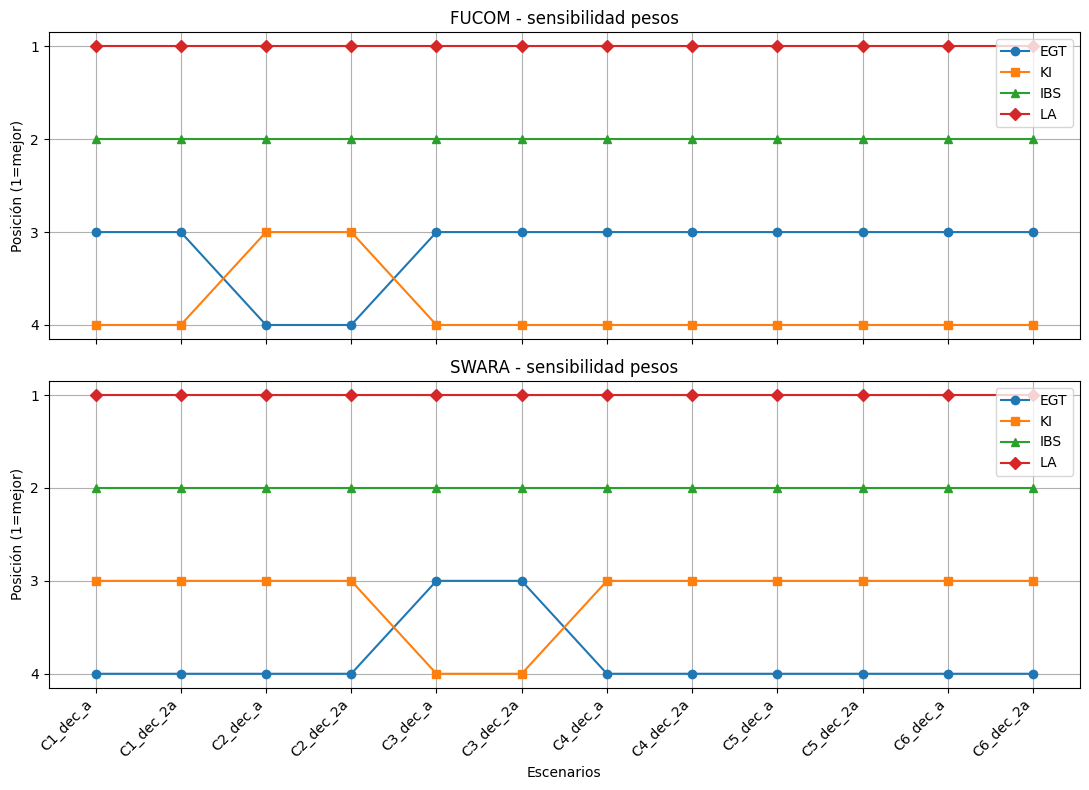


Summary sensitivity_fucom:
  EGT ha sido 1ª en 0.0% de escenarios (0/12)
  KI ha sido 1ª en 0.0% de escenarios (0/12)
  IBS ha sido 1ª en 0.0% de escenarios (0/12)
  LA ha sido 1ª en 100.0% de escenarios (12/12)
  mean_rank = [3.1667 3.8333 2.     1.    ]
  rank_range_min = [3 3 2 1]
  rank_range_max = [4 4 2 1]

Summary sensitivity_swara:
  EGT ha sido 1ª en 0.0% de escenarios (0/12)
  KI ha sido 1ª en 0.0% de escenarios (0/12)
  IBS ha sido 1ª en 0.0% de escenarios (0/12)
  LA ha sido 1ª en 100.0% de escenarios (12/12)
  mean_rank = [3.8333 3.1667 2.     1.    ]
  rank_range_min = [3 3 2 1]
  rank_range_max = [4 4 2 1]


{'fucom': {'rankings': array([[3, 4, 2, 1],
         [3, 4, 2, 1],
         [4, 3, 2, 1],
         [4, 3, 2, 1],
         [3, 4, 2, 1],
         [3, 4, 2, 1],
         [3, 4, 2, 1],
         [3, 4, 2, 1],
         [3, 4, 2, 1],
         [3, 4, 2, 1],
         [3, 4, 2, 1],
         [3, 4, 2, 1]]),
  'scenarios': ['C1_dec_a',
   'C1_dec_2a',
   'C2_dec_a',
   'C2_dec_2a',
   'C3_dec_a',
   'C3_dec_2a',
   'C4_dec_a',
   'C4_dec_2a',
   'C5_dec_a',
   'C5_dec_2a',
   'C6_dec_a',
   'C6_dec_2a']},
 'swara': {'rankings': array([[4, 3, 2, 1],
         [4, 3, 2, 1],
         [4, 3, 2, 1],
         [4, 3, 2, 1],
         [3, 4, 2, 1],
         [3, 4, 2, 1],
         [4, 3, 2, 1],
         [4, 3, 2, 1],
         [4, 3, 2, 1],
         [4, 3, 2, 1],
         [4, 3, 2, 1],
         [4, 3, 2, 1]]),
  'scenarios': ['C1_dec_a',
   'C1_dec_2a',
   'C2_dec_a',
   'C2_dec_2a',
   'C3_dec_a',
   'C3_dec_2a',
   'C4_dec_a',
   'C4_dec_2a',
   'C5_dec_a',
   'C5_dec_2a',
   'C6_dec_a',
   'C6_dec_2a']}}

In [6]:
percentage =10

sensitivity.weighting(
    fuzzy_weights_fucom = aggregated_fuzzy_weight_fucom, 
    fuzzy_weights_swara = aggregated_fuzzy_weight_swara, 
    decision_matrix_TFN = aggregated_decision_matrix_TFN, 
    criteria_type = criteria_type, 
    a = percentage,
    alts=alts
    )

### Sensitivity wrt subjetive parameters and criteria

summary_fucom['tolerance']['mean_rank'] = [3.1299 3.8658 2.0042 1.0001]
summary_fucom['tolerance']['range p_low..p_high'] = [3.0000 3.0000 2.0000 1.0000] .. [4.0000 4.0000 2.0000 1.0000]
summary_swara['tolerance']['mean_rank'] = [3.0489 3.8256 2.0939 1.0316]
summary_swara['tolerance']['range p_low..p_high'] = [3.0000 3.0000 2.0000 1.0000] .. [4.0000 4.0000 2.0000 1.0000]
summary_fucom['interest']['mean_rank'] = [3.2702 3.3151 2.3340 1.0807]
summary_fucom['interest']['range p_low..p_high'] = [2.0000 2.0000 2.0000 1.0000] .. [4.0000 4.0000 3.0000 1.0000]
summary_swara['interest']['mean_rank'] = [3.1101 3.0837 2.4706 1.3356]
summary_swara['interest']['range p_low..p_high'] = [2.0000 2.0000 1.0000 1.0000] .. [4.0000 4.0000 4.0000 2.0000]
summary_fucom['risk']['mean_rank'] = [3.3266 3.6734 2.0000 1.0000]
summary_fucom['risk']['range p_low..p_high'] = [3.0000 3.0000 2.0000 1.0000] .. [4.0000 4.0000 2.0000 1.0000]
summary_swara['risk']['mean_rank'] = [3.3809 3.6191 2.0000 1.0000]
summary_swar

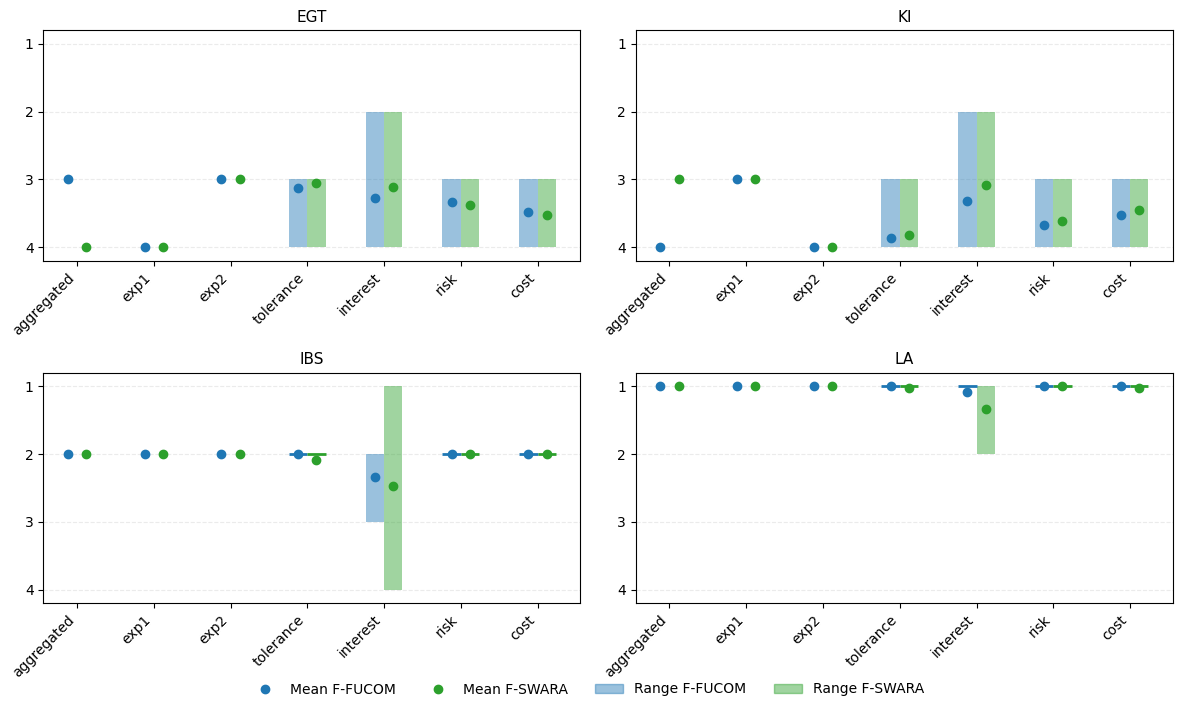

In [7]:
# Número de simulaciones (ajusta si quieres menos/más)
n_sim = 10000

# Ejecutar sensibilidad para cost (devuelve structure compatible)
out_cost = sensitivity.cost_params(
    aggregated_fuzzy_weight_fucom = aggregated_fuzzy_weight_fucom,
    aggregated_fuzzy_weight_swara = aggregated_fuzzy_weight_swara,
    aggregated_decision_matrix_TFN = aggregated_decision_matrix_TFN,
    crits = crits,
    alts = alts,
    criteria_type = criteria_type,
    n = n_sim
)

# Llamada mínima a Linguistic, pasando out_cost como extra_sensitivity_output
out_linguistic = sensitivity.linguistic(
    # FUCOM inputs
    aggregated_rank_fucom = aggregated_rank_fucom,
    expert_rankings_fucom = expert_rankings_fucom,
    aggregated_fuzzy_weight_fucom = aggregated_fuzzy_weight_fucom,
    # SWARA inputs
    aggregated_rank_swara = aggregated_rank_swara,
    expert_rankings_swara = expert_rankings_swara,
    aggregated_fuzzy_weight_swara = aggregated_fuzzy_weight_swara,
    # shared inputs
    aggregated_decision_matrix_TFN = aggregated_decision_matrix_TFN,
    crits = crits,
    alts = alts,
    criteria_type = criteria_type,
    n = n_sim,
    extra_sensitivity_output = out_cost   # <-- aquí incluimos el escenario "cost"
)


### Sensitivity wrt asteroid properties

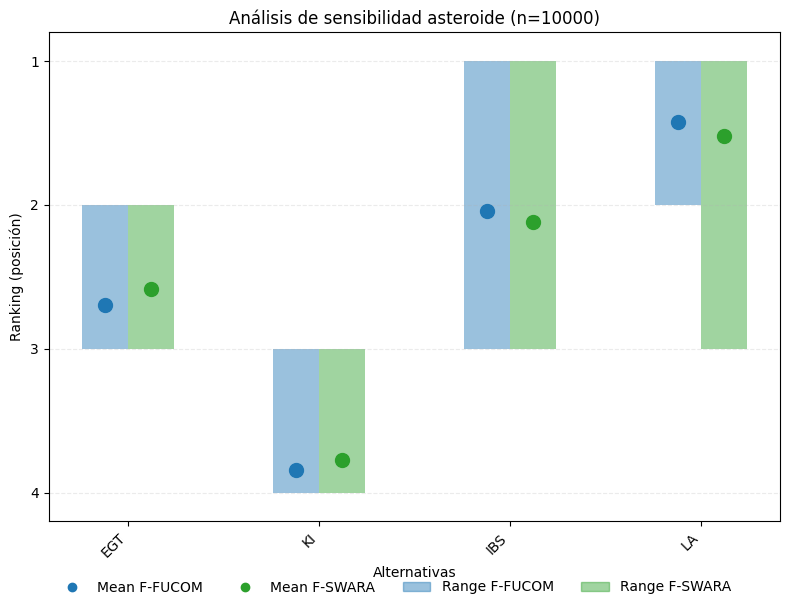

In [8]:
# Número de simulaciones (ajusta si quieres menos/más)
n_sim = 10000

# Ejecutar sensibilidad para cost (devuelve structure compatible)
out_cost = sensitivity.ast_params(
    aggregated_fuzzy_weight_fucom = aggregated_fuzzy_weight_fucom,
    aggregated_fuzzy_weight_swara = aggregated_fuzzy_weight_swara,
    aggregated_decision_matrix_TFN = aggregated_decision_matrix_TFN,
    crits = crits,
    alts = alts,
    criteria_type = criteria_type,
    n = n_sim
)